In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

colors={'direct':'#3d7f1e',
        'indirect':'#b1116d',
        'total':'darkorange'
        }

In [2]:
macsp = xr.open_dataset('../datasets/MAC-SP.nc')

emissions = pd.DataFrame({
    'Europe': [8.95, 18.26, 56.80, 16.41, 11.35],
    'North America': [7.65, 24.09, 29.32, 17.45, 7.39],
    'East Asia': [0.17, 1.69, 14.72, 37.36, 34.89],
    'South Asia': [0.18, 1.57, 9.18, 17.17, 22.89],
    'North Africa': [0.08, 0.20, 1.02, 1.70, 1.94],
    'South America': [0.12, 1.24, 4.81, 4.88, 5.26],
    'Maritime Continent': [0.03, 0.22, 2.13, 4.15, 4.43],
    'South Central Africa': [0.04, 1.42, 3.83, 3.35, 4.29],
    'Australia': [0.23, 0.63, 1.61, 1.57, 1.39],
    #'Global': [17.54, 49.32, 123.42, 104.04, 70.94]
},
index=[1900, 1950, 1980, 2005, 2013])

emission = pd.DataFrame({
    'Global': [17.54, 49.32, 123.42, 104.04, 93.83]
},
index=[1900, 1950, 1980, 2005, 2013])

sum = macsp.year_weight.sel(plume_number=1).isel(years=slice(0,164)).values * 0
for year in range(0, 164, 1):
    for plume_number in range(1, 10 ,1):
        sum[year] = sum[year] + macsp.year_weight.sel(plume_number=plume_number).isel(years=year)*emissions.iloc[:, plume_number-1].loc[2005]

def WeightedMean(var):
    weights = np.cos(np.deg2rad(var.lat))
    if len(var.shape) >= 2:
        return var.weighted(weights).mean(dim=('lat', 'lon'))
    else:
        return var.weighted(weights).mean("lat")

/tmp/ipykernel_28089/2943600938.py:32: RuntimeWarning: invalid value encountered in divide
  ax4.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values)/sum, color=colors['direct'], linestyle='-', linewidth=1.5, label='normalized by emissions')
/tmp/ipykernel_28089/2943600938.py:33: RuntimeWarning: divide by zero encountered in divide
  ax4.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values)/sum, color=colors['indirect'], linestyle='-', linewidth=1.5,label='indirect effect')


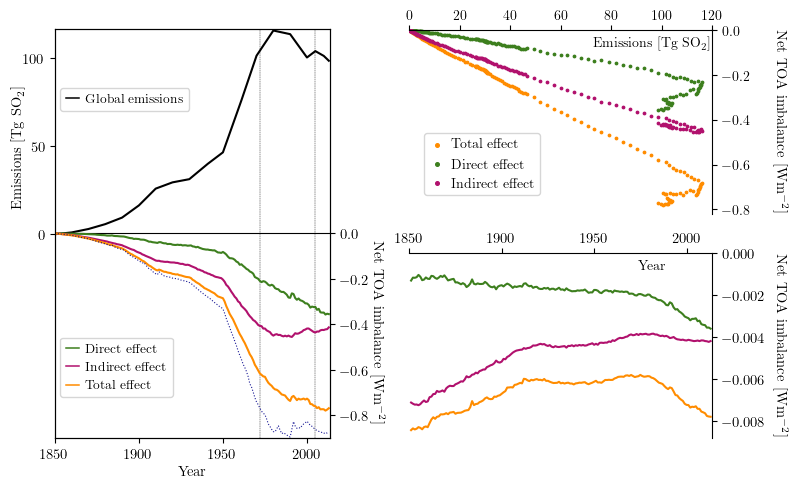

In [5]:
def plot():

    data = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig = plt.figure()
    gs = GridSpec(2,2, width_ratios=[1,1.1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    #ax1 = plt.subplot(121)
    #ax3 = plt.subplot(223)
    #ax4 = plt.subplot(224)
    #fig, axs = plt.subplots(2,2,figsize=(6,6), gridspec_kw={'width_ratios': [2, 2]})
    #fig.delaxes(axs[1, 0])

    #ax1 = axs[0,0]
    ax2 = ax1.twinx()

    time = np.arange(1850, 1850 + data.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)

    ax2.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values), color=colors['direct'], linestyle='-', label='direct effect')
    ax2.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', label='indirect effect')
    ax2.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0), 'darkorange', linestyle='-', label='total effect')
    ax2.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0), 'darkblue', linestyle=':', linewidth=0.8, alpha=0.9, label='aerosol effect clear-sky')
   
    #ax2.plot(time, (data.dR_spd_sraf0.values + data.dR_spd_traf0), 'darkblue', linestyle='-', linewidth=1,label='aerosol effect clear-sky')

    ax4.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values)/sum, color=colors['direct'], linestyle='-', linewidth=1.5, label='normalized by emissions')
    ax4.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values)/sum, color=colors['indirect'], linestyle='-', linewidth=1.5,label='indirect effect')
    ax4.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0)/sum, 'darkorange', linestyle='-', linewidth=1.5,label='total effect')
    #ax4.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0)/sum, 'darkblue', linestyle='-', linewidth=1.5,label='clear-sky')
    
    ax1.plot(time, sum, 'black', label='Global emissions')

    ax2.set_ylim([-.9, .9])    
    ax1.set_ylim([-max(sum), max(sum)+1])   

    ms=3
    #macsp = xr.open_dataset('..//MAC-SP.nc')
    effects = ['total', 'direct', 'indirect',
               # 'clear-sky'
                ]
    for effect in effects:
        if effect == 'direct':
             ax3.scatter(sum, data[f'dR_spd_srad0'] + data[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
        elif effect == 'indirect':
            ax3.scatter(sum, data[f'dR_spi_srad0'] + data[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
        elif effect == 'total':
            ax3.scatter(sum, data[f'dR_sp_srad0'] + data[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)  
        elif effect == 'clear-sky':
            ax3.scatter(sum, data[f'dR_spd_sraf0'] + data[f'dR_spd_traf0'], label='Clear-sky', color='darkblue', s=ms)  
    
    for ax in [ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none') 
        ax.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    fs=10.5
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.set_xlim([0, 120])
    ax3.set_ylim([None, 0.005])
    ax3.xaxis.set_label_coords(.8, .96)
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax3.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.1), markerscale=1.5)
    ax3.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax3.yaxis.set_label_coords(1.2,0.5)
    
    ax4.set_xlabel(r"Year")
    ax4.set_xlim([1850, 2014])
    ax4.set_ylim([None, 0.00])
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.set_xticks(np.arange(1850, 2001, 50))
    ax4.xaxis.set_label_coords(.8, .96)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax4.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax4.yaxis.set_label_coords(1.2,0.5)
    #ax4.legend(frameon=True, ncol=1,
    #            handletextpad=0.5, handlelength=1.0, loc=(0.05,.2), markerscale=1.5)

    plt.subplots_adjust(wspace=0.4)

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    ax2.yaxis.get_major_ticks()[6].set_visible(False)
    ax2.yaxis.get_major_ticks()[7].set_visible(False)
    ax2.yaxis.get_major_ticks()[8].set_visible(False)
    ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_data, data.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2014])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))
    #plt.ylim([-0.2, None])
    #ax1.legend(loc=(0.01, 0.8))
    fig = plt.gcf()
    fig.set_size_inches(8, 5)

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=1.1),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", #"Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)
    

    plt.tight_layout()
    plt.savefig(f'../figures/historical-forcing.pdf',bbox_inches='tight')
    
plot()

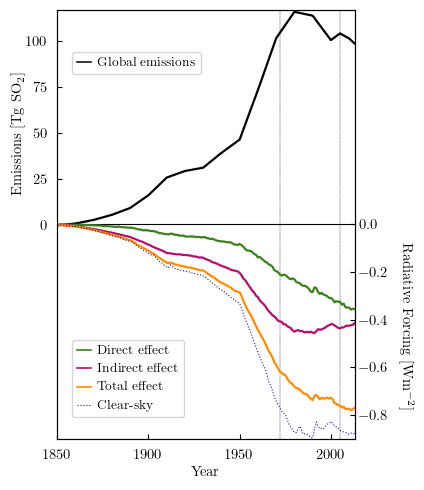

In [4]:
def plot():

    data = xr.open_dataset('../datasets/historical_simple-plumes_fldmean_yearmean.nc').squeeze()

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    time = np.arange(1850, 1850 + data.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)

    lw = 1.6
    ax2.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values), color=colors['direct'], linestyle='-', linewidth=lw, label='direct effect')
    ax2.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', linewidth=lw, label='indirect effect')
    ax2.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0), 'darkorange', linestyle='-', linewidth=lw, label='total effect')
    ax2.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0), 'darkblue', linestyle=':', linewidth=0.8, alpha=0.9, label='aerosol effect clear-sky')
    ax1.plot(time, sum, 'black', linewidth=lw, label='Global emissions')

    ax2.set_ylim([-.9, .9])    
    ax1.set_ylim([-max(sum), max(sum)+1])   

    plt.subplots_adjust(wspace=0.4)

    #ax1.yaxis.get_major_ticks()[1].set_visible(False)
    #ax1.yaxis.get_major_ticks()[2].set_visible(False)

    #ax2.yaxis.get_major_ticks()[6].set_visible(False)
    #ax2.yaxis.get_major_ticks()[7].set_visible(False)
    #ax2.yaxis.get_major_ticks()[8].set_visible(False)
    #ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_data, data.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.set_yticks([0, 25, 50, 75, 100])
    ax1.yaxis.set_label_coords(-.11,0.71)

    ax2.set_yticks([-0.8, -0.6, -0.4, -0.2, 0])
    ax2.set_ylabel(r'Radiative Forcing [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2013])
    ax1.tick_params(axis='both', which='major', direction='in', labelsize=fs,  pad=7)
    ax2.tick_params(axis='both', which='major', direction='in', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.05,0.85))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=0.8, alpha=0.9, linestyle=':'),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.05,0.05))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)

    fig = plt.gcf()
    fig.set_size_inches(4.5, 5)
    

    plt.tight_layout()
    plt.savefig(f'../figures/figure1.pdf',bbox_inches='tight')
    
plot()

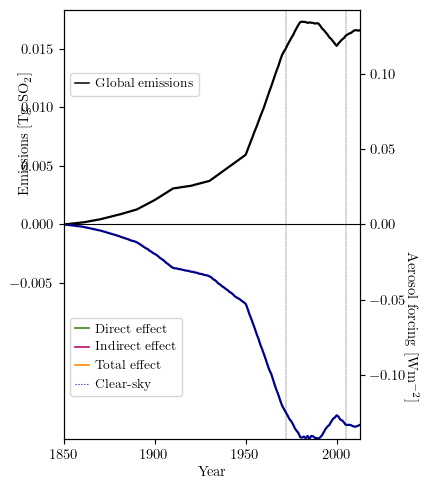

In [8]:
def plot():

    data = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()

    time = np.arange(1850, 1850 + data.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)

    lw = 1.6
    ax1.plot(time, WeightedMean(data.aod_sp), 'black', linewidth=lw, label='Global emissions')

    albedo = - (data.sraf0 - data.srad0d)/(data.srad0d)
    sum = data.dR_sp_sraf0*0
    for plume_number in range(1, 10, 1):
        #label=macsp.attrs[f'plume{plume_number}_region']
          
        forcing = data[f'dR_spd{plume_number}_sraf0'] + data[f'dR_spd{plume_number}_traf0']
        sum =+ forcing*albedo
    
    result = WeightedMean(sum)

    result = WeightedMean(data.dR_sp_sraf0*albedo)
 
    ax2.plot(time, result, color='darkblue', linestyle='-', linewidth=lw, label='direct effect')
    #ax2.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', linewidth=lw, label='indirect effect')
    #ax2.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0), 'darkorange', linestyle='-', linewidth=lw, label='total effect')
    #ax2.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0), 'darkblue', linestyle=':', linewidth=0.8, alpha=0.9, label='aerosol effect clear-sky')
    
    ax2.set_ylim([min(result), -min(result)])    
    ax1.set_ylim([-max(WeightedMean(data.aod_sp))-0.001, max(WeightedMean(data.aod_sp))+0.001])   

    plt.subplots_adjust(wspace=0.4)

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    #ax2.yaxis.get_major_ticks()[6].set_visible(False)
    #ax2.yaxis.get_major_ticks()[7].set_visible(False)
    #ax2.yaxis.get_major_ticks()[8].set_visible(False)
    #ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_data, data.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Aerosol forcing [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2013])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.2),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=0.8, alpha=0.9, linestyle=':'),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)

    fig = plt.gcf()
    fig.set_size_inches(4.5, 5)
    

    plt.tight_layout()
    #plt.savefig(f'../figures/figure1.pdf',bbox_inches='tight')
    
plot()

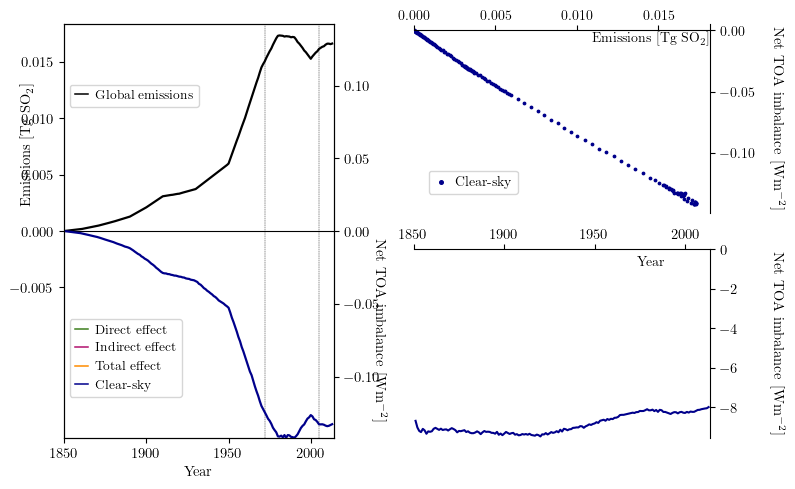

In [6]:
def plot():

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig = plt.figure()
    gs = GridSpec(2,2, width_ratios=[1,1.1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    #ax1 = plt.subplot(121)
    #ax3 = plt.subplot(223)
    #ax4 = plt.subplot(224)
    #fig, axs = plt.subplots(2,2,figsize=(6,6), gridspec_kw={'width_ratios': [2, 2]})
    #fig.delaxes(axs[1, 0])

    #ax1 = axs[0,0]
    ax2 = ax1.twinx()

    data = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()
    #data = xr.open_dataset('../fmbg_ssa/datasets/temp.nc').squeeze()

    time = np.arange(1850, 1850 + data.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)
    lw = 1.6
    ax1.plot(time, WeightedMean(data.aod_sp), 'black', linewidth=lw, label='Global emissions')

    albedo = - (data.sraf0 - data.srad0d)/(data.srad0d)
    #sum = data.dR_sp_sraf0*0
    #for plume_number in range(1, 10, 1):
        #label=macsp.attrs[f'plume{plume_number}_region']
          
    #    forcing = data[f'dR_spd{plume_number}_sraf0'] + data[f'dR_spd{plume_number}_traf0']
    #    sum =+ forcing*albedo
    
    #result = WeightedMean(sum)

    result = WeightedMean(data.dR_sp_sraf0*albedo)
 
    ax2.plot(time, result, color='darkblue', linestyle='-', linewidth=lw, label='direct effect')

    ax2.set_ylim([min(result), -min(result)])    
    ax1.set_ylim([-max(WeightedMean(data.aod_sp))-0.001, max(WeightedMean(data.aod_sp))+0.001]) 
    #ax2.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', linewidth=lw, label='indirect effect')
    #ax2.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0), 'darkorange', linestyle='-', linewidth=lw, label='total effect')
    #ax2.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0), 'darkblue', linestyle=':', linewidth=0.8, alpha=0.9, label='aerosol effect clear-sky')

    #ax4.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values)/data.aod_sp, color=colors['direct'], linestyle='-', linewidth=1.5, label='normalized by emissions')
    #ax4.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values)/data.aod_sp, color=colors['indirect'], linestyle='-', linewidth=1.5,label='indirect effect')
    #ax4.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0)/data.aod_sp, 'darkorange', linestyle='-', linewidth=1.5,label='total effect')
    ax4.plot(time, result/WeightedMean(data.aod_sp), 'darkblue', linestyle='-', linewidth=1.5,label='clear-sky')

    ms=3
    #macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')
    #effects = ['total', 'direct', 'indirect', 'clear-sky']
    #for effect in effects:
        #if effect == 'direct':
        #     ax3.scatter(prp.aod_sp, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
        #elif effect == 'indirect':
        #    ax3.scatter(prp.aod_sp, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
        #elif effect == 'total':
        #    ax3.scatter(prp.aod_sp, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)  
        #elif effect == 'clear-sky':
    ax3.scatter(WeightedMean(data.aod_sp), result, label='Clear-sky', color='darkblue', s=ms)  
    
    for ax in [ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none') 
        ax.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    fs=10.5
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.set_xlim([0, None])
    ax3.set_ylim([None, 0.005])
    ax3.xaxis.set_label_coords(.8, .96)
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax3.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.1), markerscale=1.5)
    ax3.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax3.yaxis.set_label_coords(1.2,0.5)
    
    ax4.set_xlabel(r"Year")
    ax4.set_xlim([1850, 2014])
    ax4.set_ylim([None, 0.00])
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.set_xticks(np.arange(1850, 2001, 50))
    ax4.xaxis.set_label_coords(.8, .96)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax4.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax4.yaxis.set_label_coords(1.2,0.5)
    #ax4.legend(frameon=True, ncol=1,
    #            handletextpad=0.5, handlelength=1.0, loc=(0.05,.2), markerscale=1.5)

    plt.subplots_adjust(wspace=0.4)

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    #ax2.yaxis.get_major_ticks()[6].set_visible(False)
    #ax2.yaxis.get_major_ticks()[7].set_visible(False)
    #ax2.yaxis.get_major_ticks()[8].set_visible(False)
    #ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_prp, prp.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2014])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))
    #plt.ylim([-0.2, None])
    #ax1.legend(loc=(0.01, 0.8))
    fig = plt.gcf()
    fig.set_size_inches(8, 5)

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=1.1),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)
    

    plt.tight_layout()
    #plt.savefig(f'../figures/global-forcing.pdf',bbox_inches='tight')
    
plot()

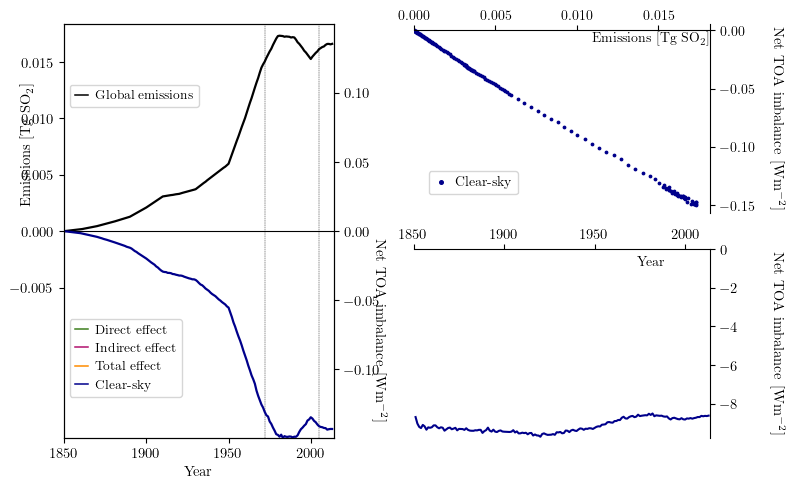

In [5]:
def plot():

    #fig = plt.gcf()
    #fig.set_size_inches(10, 8)
    fig = plt.figure()
    gs = GridSpec(2,2, width_ratios=[1,1.1])
    ax1 = fig.add_subplot(gs[:, 0])
    ax3 = fig.add_subplot(gs[0, 1])
    ax4 = fig.add_subplot(gs[1, 1])
    #ax1 = plt.subplot(121)
    #ax3 = plt.subplot(223)
    #ax4 = plt.subplot(224)
    #fig, axs = plt.subplots(2,2,figsize=(6,6), gridspec_kw={'width_ratios': [2, 2]})
    #fig.delaxes(axs[1, 0])

    #ax1 = axs[0,0]
    ax2 = ax1.twinx()

    #data = xr.open_dataset('../datasets/historical_simple-plumes_yearmean.nc').squeeze()
    data = xr.open_dataset('../fmbg_ssa/datasets/temp.nc').squeeze()

    time = np.arange(1850, 1850 + data.time.size, 1)

    plt.axhline(0, color='black', linewidth=0.8)
    lw = 1.6
    ax1.plot(time, WeightedMean(data.aod_sp), 'black', linewidth=lw, label='Global emissions')

    albedo = - (data.sraf0 - data.srad0d)/(data.srad0d)
    #sum = data.dR_sp_sraf0*0
    #for plume_number in range(1, 10, 1):
        #label=macsp.attrs[f'plume{plume_number}_region']
          
    #    forcing = data[f'dR_spd{plume_number}_sraf0'] + data[f'dR_spd{plume_number}_traf0']
    #    sum =+ forcing*albedo
    
    #result = WeightedMean(sum)

    result = WeightedMean(data.dR_sp_sraf0*albedo)
 
    ax2.plot(time, result, color='darkblue', linestyle='-', linewidth=lw, label='direct effect')

    ax2.set_ylim([min(result), -min(result)])    
    ax1.set_ylim([-max(WeightedMean(data.aod_sp))-0.001, max(WeightedMean(data.aod_sp))+0.001]) 
    #ax2.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values), color=colors['indirect'], linestyle='-', linewidth=lw, label='indirect effect')
    #ax2.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0), 'darkorange', linestyle='-', linewidth=lw, label='total effect')
    #ax2.plot(time, (data.dR_sp_sraf0.values + data.dR_sp_traf0), 'darkblue', linestyle=':', linewidth=0.8, alpha=0.9, label='aerosol effect clear-sky')

    #ax4.plot(time, (data.dR_spd_srad0.values + data.dR_spd_trad0.values)/data.aod_sp, color=colors['direct'], linestyle='-', linewidth=1.5, label='normalized by emissions')
    #ax4.plot(time, (data.dR_spi_srad0.values + data.dR_spi_trad0.values)/data.aod_sp, color=colors['indirect'], linestyle='-', linewidth=1.5,label='indirect effect')
    #ax4.plot(time, (data.dR_sp_srad0.values + data.dR_sp_trad0)/data.aod_sp, 'darkorange', linestyle='-', linewidth=1.5,label='total effect')
    ax4.plot(time, result/WeightedMean(data.aod_sp), 'darkblue', linestyle='-', linewidth=1.5,label='clear-sky')

    ms=3
    #macsp = xr.open_dataset(f'{MACSP_dir}/MAC-SP.nc')
    #effects = ['total', 'direct', 'indirect', 'clear-sky']
    #for effect in effects:
        #if effect == 'direct':
        #     ax3.scatter(prp.aod_sp, prp[f'dR_spd_srad0'] + prp[f'dR_spd_trad0'], label='Direct effect', color=colors['direct'], s=ms)
        #elif effect == 'indirect':
        #    ax3.scatter(prp.aod_sp, prp[f'dR_spi_srad0'] + prp[f'dR_spi_trad0'], label='Indirect effect', color=colors['indirect'], s=ms)
        #elif effect == 'total':
        #    ax3.scatter(prp.aod_sp, prp[f'dR_sp_srad0'] + prp[f'dR_sp_trad0'], label='Total effect', color='darkorange', s=ms)  
        #elif effect == 'clear-sky':
    ax3.scatter(WeightedMean(data.aod_sp), result, label='Clear-sky', color='darkblue', s=ms)  
    
    for ax in [ax3, ax4]:
        ax.spines['bottom'].set_position('zero')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none') 
        ax.tick_params(axis='y', labelright=True, labelleft=False, right=True, left=False)

    fs=10.5
    ax3.set_xlabel(r"Emissions [Tg SO$_2$]")
    ax3.set_xlim([0, None])
    ax3.set_ylim([None, 0.005])
    ax3.xaxis.set_label_coords(.8, .96)
    ax3.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax3.legend(frameon=True, ncol=1,
                handletextpad=0.5, handlelength=1.0, loc=(0.05,.1), markerscale=1.5)
    ax3.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax3.yaxis.set_label_coords(1.2,0.5)
    
    ax4.set_xlabel(r"Year")
    ax4.set_xlim([1850, 2014])
    ax4.set_ylim([None, 0.00])
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.tick_params(axis='both', which='major', labelsize=fs)
    ax4.set_xticks(np.arange(1850, 2001, 50))
    ax4.xaxis.set_label_coords(.8, .96)
    ax4.tick_params(axis='x', direction='in', which='major', pad=-15)
    ax4.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax4.yaxis.set_label_coords(1.2,0.5)
    #ax4.legend(frameon=True, ncol=1,
    #            handletextpad=0.5, handlelength=1.0, loc=(0.05,.2), markerscale=1.5)

    plt.subplots_adjust(wspace=0.4)

    ax1.yaxis.get_major_ticks()[1].set_visible(False)
    ax1.yaxis.get_major_ticks()[2].set_visible(False)

    #ax2.yaxis.get_major_ticks()[6].set_visible(False)
    #ax2.yaxis.get_major_ticks()[7].set_visible(False)
    #ax2.yaxis.get_major_ticks()[8].set_visible(False)
    #ax2.yaxis.get_major_ticks()[9].set_visible(False)

    fs=10.5
    #plt.plot(time_prp, prp.dR_aer_srad0.values, 'darkblue', linestyle='--')
    ax1.set_xlabel('Year', fontsize=fs)
    ax1.set_ylabel(r'Emissions [Tg SO$_2$]', fontsize=fs, labelpad=30)
    ax1.yaxis.set_label_coords(-.11,0.71)
    ax2.set_ylabel(r'Net TOA imbalance [Wm$^{-2}$]', rotation=-90, labelpad=70, fontsize=fs)
    ax2.yaxis.set_label_coords(1.2,0.26)

    ax1.set_xlim([1850, 2014])
    ax1.tick_params(axis='both', which='major', labelsize=fs)
    ax2.tick_params(axis='both', which='major', labelsize=fs)
    plt.xticks(np.arange(1850, 2001, 50))
    #plt.ylim([-0.2, None])
    #ax1.legend(loc=(0.01, 0.8))
    fig = plt.gcf()
    fig.set_size_inches(8, 5)

    legend_elements = [
    Line2D([0],[2],color="black",markerfacecolor="black",markersize=10,linewidth=1.1)
    ]
    labels = ["Global emissions"]
    ax1.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.8))

    legend_elements = [
    Line2D([0],[2],color=colors['direct'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color=colors['indirect'],markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkorange",markerfacecolor="black",markersize=10,linewidth=1.1),
    Line2D([0],[2],color="darkblue",markerfacecolor="black",markersize=10,linewidth=1.1),
    ]
    labels = ["Direct effect", "Indirect effect", "Total effect", "Clear-sky"
]
    leg = ax2.legend(handles=legend_elements, frameon=True, ncol=1, labels=labels, fontsize=9.5,
    handletextpad=0.5, handlelength=1.0, loc=(0.02,0.1))

    ax1.axvline(x=1972, color='black', linewidth=0.3, linestyle='--')
    ax1.axvline(x=2005, color='black', linewidth=0.3, linestyle='--')
    plt.subplots_adjust(wspace=0.4)

    leg.set_zorder(1)
    

    plt.tight_layout()
    #plt.savefig(f'../figures/global-forcing.pdf',bbox_inches='tight')
    
plot()